#Library and data load

In [1]:
import os
import datetime as dt
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

In [14]:
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


In [3]:
path='DatosPrueba.csv'
df = pd.read_csv(path, sep=";", index_col="Unnamed: 0")
df.head()

,Unnamed: 0.1,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,"45,0",Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"46,2306","-112,1138",1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,"47,034331","-112,561071",0
10,10,2019-01-01 00:06:23,4642894980163,fraud_Rutherford-Mertz,grocery_pos,"24,74",Eddie,Mendez,M,1831 Faith View Suite 653,Clarinda,IA,51632,"40,7491","-95,038",7297,IT trainer,1990-07-13,d71c95ab6b7356dd74389d41df429c87,1325376383,"40,275891","-96,011548",0
27,27,2019-01-01 00:21:32,4334230547694630,fraud_Bruen-Yost,misc_pos,"6,85",Scott,Martin,M,7483 Navarro Flats,Freedom,WY,83120,"43,0172","-111,0292",471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,1325377292,"43,753735","-111,454923",0
32,32,2019-01-01 00:22:44,630412733309,fraud_Torphy-Goyette,shopping_pos,"66,21",Heather,Stanton,F,445 Jerry Lights Apt. 081,Republic,MI,49879,"46,368","-87,9938",1038,Armed forces training and education officer,1964-04-22,20f048d3907dbb9978e23bee7b7578ce,1325377364,"46,412038","-88,516663",0
34,34,2019-01-01 00:23:58,374125201044065,"fraud_Bahringer, Schoen and Corkery",shopping_pos,"9,03",Christopher,Gilbert,M,20937 Reed Lakes Apt. 271,Washington,DC,20012,"38,9757","-77,0282",601723,"Optician, dispensing",1970-07-20,c733711c521c41c578f4a964d8350df0,1325377438,"38,880898","-76,44111600000002",0


Dataset required small adjustments to get indexes as the originals in the file

In [4]:
df = pd.read_csv(path, sep=";", index_col="Unnamed: 0").drop(columns=["Unnamed: 0.1"], axis=1)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,"45,0",Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"46,2306","-112,1138",1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,"47,034331","-112,561071",0
10,2019-01-01 00:06:23,4642894980163,fraud_Rutherford-Mertz,grocery_pos,"24,74",Eddie,Mendez,M,1831 Faith View Suite 653,Clarinda,IA,51632,"40,7491","-95,038",7297,IT trainer,1990-07-13,d71c95ab6b7356dd74389d41df429c87,1325376383,"40,275891","-96,011548",0
27,2019-01-01 00:21:32,4334230547694630,fraud_Bruen-Yost,misc_pos,"6,85",Scott,Martin,M,7483 Navarro Flats,Freedom,WY,83120,"43,0172","-111,0292",471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,1325377292,"43,753735","-111,454923",0
32,2019-01-01 00:22:44,630412733309,fraud_Torphy-Goyette,shopping_pos,"66,21",Heather,Stanton,F,445 Jerry Lights Apt. 081,Republic,MI,49879,"46,368","-87,9938",1038,Armed forces training and education officer,1964-04-22,20f048d3907dbb9978e23bee7b7578ce,1325377364,"46,412038","-88,516663",0
34,2019-01-01 00:23:58,374125201044065,"fraud_Bahringer, Schoen and Corkery",shopping_pos,"9,03",Christopher,Gilbert,M,20937 Reed Lakes Apt. 271,Washington,DC,20012,"38,9757","-77,0282",601723,"Optician, dispensing",1970-07-20,c733711c521c41c578f4a964d8350df0,1325377438,"38,880898","-76,44111600000002",0


#Dataset characterization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   trans_date_trans_time  200881 non-null  object
 1   cc_num                 200881 non-null  int64 
 2   merchant               200881 non-null  object
 3   category               200881 non-null  object
 4   amt                    200881 non-null  object
 5   first                  200881 non-null  object
 6   last                   200881 non-null  object
 7   gender                 200881 non-null  object
 8   street                 200881 non-null  object
 9   city                   200881 non-null  object
 10  state                  200881 non-null  object
 11  zip                    200881 non-null  int64 
 12  lat                    200881 non-null  object
 13  long                   200881 non-null  object
 14  city_pop               200881 non-null  int64 
 15 

## Variable groups

First let's group up variables

### Client information

* [int] cc_num: Client's credit card number

* [str] first: Client's first name

* [str] last: Client's last name

* [str] gender: Client's sexual gender

* [str] street: Client's address

* [str] city: Client's home city

* [str] state: Client's home state

* [int] zip: Client's home zip code

* [str] lat: Client's latitude (georeferencing). Requires float parsing

* [str] lon: Client's longitude (georeferencing). Requires float parsing 

* [int] city_pop: Client's home city population

* [str] job: Client's profession

* [str] dob: Client's date of birth

### Requesting company

* [str] merchant: Requesting Company name

* [str] category: Requesting Company economic activity

* [str] merch_lat: Requesting Company latitude (georeferencing). Requires float parsing

* [str] merch_long: Requesting Company longitude (georeferencing). Requires float parsing

### Transaction

* [str] trans_date_trans_time: Transaction timestamp. Requires datetime parsing

* [str] amt: Transaction's requested value

* [str] trans_num: Transaction's unique id

* [int] unix_time: transaction elapsed time

* [int] is_fraud: Boolean tag for previously identified frauds.

#First features filter

Lets stablish some basic heuristics for a first filter, discarding variables that do no hold relation with fraud or are redundant

## Client information
Client id contains several fields for client identification. Yet, we look for characteristics that might help out noticing fraud risk. Keeping that in mind, we discard the following variables:

* first / last: Client name has no relation to fraud risk, this is just client's information

* street / zip: Client's location can be related using lat and long

## Transaction

* trans_num: Transaction's unique id is generated on demand and does not depend on neither client nor commerce

Variables not tagged for deletion are not necessarily useful on fraud prediction. Their importance is yet to be determined

In [6]:
df = df.drop(columns=['first', 'last', 'street', 'zip', 'trans_num'], errors='ignore')
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,"45,0",M,Boulder,MT,"46,2306","-112,1138",1939,Patent attorney,1967-01-12,1325376076,"47,034331","-112,561071",0
10,2019-01-01 00:06:23,4642894980163,fraud_Rutherford-Mertz,grocery_pos,"24,74",M,Clarinda,IA,"40,7491","-95,038",7297,IT trainer,1990-07-13,1325376383,"40,275891","-96,011548",0
27,2019-01-01 00:21:32,4334230547694630,fraud_Bruen-Yost,misc_pos,"6,85",M,Freedom,WY,"43,0172","-111,0292",471,"Education officer, museum",1967-08-02,1325377292,"43,753735","-111,454923",0
32,2019-01-01 00:22:44,630412733309,fraud_Torphy-Goyette,shopping_pos,"66,21",F,Republic,MI,"46,368","-87,9938",1038,Armed forces training and education officer,1964-04-22,1325377364,"46,412038","-88,516663",0
34,2019-01-01 00:23:58,374125201044065,"fraud_Bahringer, Schoen and Corkery",shopping_pos,"9,03",M,Washington,DC,"38,9757","-77,0282",601723,"Optician, dispensing",1970-07-20,1325377438,"38,880898","-76,44111600000002",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296651,2020-06-21 12:03:37,6534628260579800,"fraud_Wintheiser, Dietrich and Schimmel",misc_pos,"7,38",F,Hinesburg,VT,"44,3346","-73,098",4542,Claims inspector/assessor,1998-03-19,1371816217,"44,006334","-72,579624",0
1296656,2020-06-21 12:07:09,4158945090781624,"fraud_Wintheiser, Dietrich and Schimmel",misc_pos,"5,48",M,Pittsburgh,PA,"40,4308","-79,9205",687276,"Scientist, marine",1973-10-19,1371816429,"40,810441","-79,181444",0
1296664,2020-06-21 12:08:36,3531129874770000,"fraud_Larkin, Stracke and Greenfelder",entertainment,"69,38",F,Brandon,VT,"43,8065","-73,0882",5895,"Scientist, marine",1975-07-13,1371816516,"43,808957","-72,277168",0
1296666,2020-06-21 12:09:22,4587657402165341815,"fraud_Hyatt, Russel and Gleichner",health_fitness,"7,3",F,Pembroke Township,IL,"41,0646","-87,5917",2135,"Psychotherapist, child",2004-05-08,1371816562,"40,556811","-88,092339",0


# Dataset preparation

In adition to previously mentioned parsings required, it is desirable to avoid categorical string variables. So we are going to find ways to transform string categoricals into numerical

## Lat / long / amt float parsing

In [7]:
df["amt"] = pd.to_numeric(df["amt"].apply(lambda x: x.replace(',','.')), downcast='float')
df["lat"] = pd.to_numeric(df["lat"].apply(lambda x: x.replace(',','.')), downcast='float')
df["long"] = pd.to_numeric(df["long"].apply(lambda x: x.replace(',','.')), downcast='float',)
df["merch_lat"] = pd.to_numeric(df["merch_lat"].apply(lambda x: x.replace(',','.')), downcast='float')
df["merch_long"] = pd.to_numeric(df["merch_long"].apply(lambda x: x.replace(',','.')), downcast='float')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  200881 non-null  object 
 1   cc_num                 200881 non-null  int64  
 2   merchant               200881 non-null  object 
 3   category               200881 non-null  object 
 4   amt                    200881 non-null  float32
 5   gender                 200881 non-null  object 
 6   city                   200881 non-null  object 
 7   state                  200881 non-null  object 
 8   lat                    200881 non-null  float32
 9   long                   200881 non-null  float32
 10  city_pop               200881 non-null  int64  
 11  job                    200881 non-null  object 
 12  dob                    200881 non-null  object 
 13  unix_time              200881 non-null  int64  
 14  merch_lat              200881 non-n

## Categorical binarization

> Gender, city and state are binarizable since they have limited possible values.

> In prediction techniques it is desirable to have the less ammount of categorical str variables

> One-hot encoding is used on variable binarization. Yet, it adds as many columns as categories, so a unique multivalue column is used instead

In [9]:
df_cities = pd.read_csv('https://github.com/Dialvec/USA_Locations_Codes/raw/main/USA_cities.csv', index_col="city_code")
df_cities.head()

,city,state_short,state_full
city_code,,,
1,Apo,AE,US Armed Forces Europe
2,DPO,AE,US Armed Forces Europe
3,FPO,AE,US Armed Forces Europe
4,Fpo,AE,US Armed Forces Europe
5,Adak,AK,Alaska


In [10]:
df_states = pd.read_csv('https://github.com/Dialvec/USA_Locations_Codes/raw/main/US_States_FIPS_Code.csv', index_col="FIPS")
df_states.head()

,Name,Short
FIPS,,
1,Alabama,AL
2,Alaska,AK
4,Arizona,AZ
5,Arkansas,AR
6,California,CA


In [11]:
def get_city_code(cityname):
  if cityname in df_cities['city'].values:
    return df_cities[df_cities['city']==cityname].index[0]
  else:
    return 0

In [12]:
def get_city_name(citycode):
  if citycode in df_cities.index.values:
    return df_cities.loc[citycode]['city']
  else:
    return "null"

In [13]:
def get_state_code(stateshort):
  if stateshort in df_states['Short'].values:
    return df_states[df_states['Short']==stateshort].index[0]
  else:
    return 0

In [14]:
def get_state_full_name(statecode):
  if statecode in df_states.index.values:
    return df_states.loc[statecode]['Name']
  else:
    return "null"

In [15]:
def get_state_short_name(statecode):
  if statecode in df_states.index.values:
    return df_states.loc[statecode]['Short']
  else:
    return "null"

In [16]:
df['gender'] = pd.to_numeric(df['gender'].apply(lambda x: 0 if x=="M" else 1 if x=="F" else -1))
df['state_code'] = pd.to_numeric(df['state'].apply(lambda x: get_state_code(x)))
df['city_code'] = pd.to_numeric(df['city'].apply(lambda x: get_city_code(x)))
df.drop(columns=['state', 'city'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  200881 non-null  object 
 1   cc_num                 200881 non-null  int64  
 2   merchant               200881 non-null  object 
 3   category               200881 non-null  object 
 4   amt                    200881 non-null  float32
 5   gender                 200881 non-null  int64  
 6   lat                    200881 non-null  float32
 7   long                   200881 non-null  float32
 8   city_pop               200881 non-null  int64  
 9   job                    200881 non-null  object 
 10  dob                    200881 non-null  object 
 11  unix_time              200881 non-null  int64  
 12  merch_lat              200881 non-null  float32
 13  merch_long             200881 non-null  float32
 14  is_fraud               200881 non-n

## Merchant name and category as features


Let see if there a pattern on merchant names found being fraud

In [18]:
len(df[df['is_fraud']==1]['merchant'].unique())/len(df['merchant'].unique())

0.9797979797979798

97% of the merchan names are associated to having at least 1 fraud event

Text(0.5, 0.98, 'Merchants with the highest fraud rates')

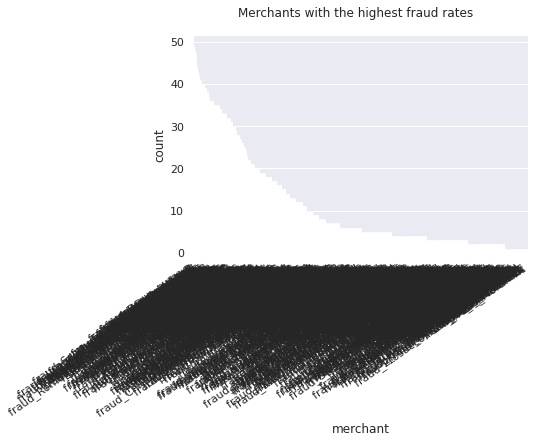

In [19]:
sns.countplot(
    data=df[df['is_fraud']==1], 
    x = "merchant", 
    order=df[df['is_fraud']==1]['merchant'].value_counts().index
    )
plt.xticks(rotation=35, ha='right')
plt.suptitle('Merchants with the highest fraud rates')

In [20]:
highest_fraud_merchant = df[df['is_fraud']==1]['merchant'].value_counts().index[0]
df[df['merchant']==highest_fraud_merchant][df['is_fraud']==1].shape[0]/df[df['merchant']==highest_fraud_merchant].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1198044009779951

**The highest merchant where fraud happens  has only 11.98% fraud rate. Then, merchant names are not a feasible feature**

Text(0.5, 0.98, 'Categories with the highest fraud rates')

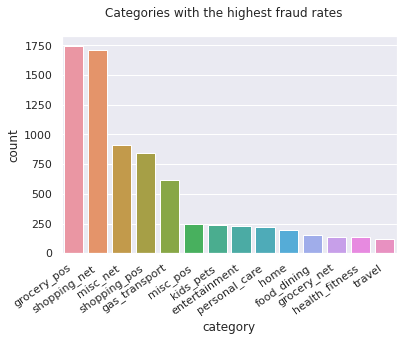

In [21]:
sns.countplot(
    data=df[df['is_fraud']==1], 
    x = "category", 
    order=df[df['is_fraud']==1]['category'].value_counts().index
    )
plt.xticks(rotation=35, ha='right')
plt.suptitle('Categories with the highest fraud rates')

Category is a binarizable feature that has potential of being a good feature since there are 5 categories that hold most of the frauds.

A list of highest fraud risk companies is created to define category with a numeric index relatex to how high is the fraud risk

In [22]:
cat_list = df[df['is_fraud']==1]['category'].value_counts().index

df_cat_risk=pd.DataFrame()
df_cat_risk['category']=cat_list
df_cat_risk.index=list(range(1, len(cat_list)+1) )
df_cat_risk

,category
1,grocery_pos
2,shopping_net
3,misc_net
4,shopping_pos
5,gas_transport
6,misc_pos
7,kids_pets
8,entertainment
9,personal_care
10,home


In [23]:
def get_category_risk_score(category):
  if category in df_cat_risk['category'].values:
    return df_cat_risk[df_cat_risk['category']==category].index[0]
  else:
    return 0

Text(0.5, 0.98, 'Jobs with the highest fraud rates')

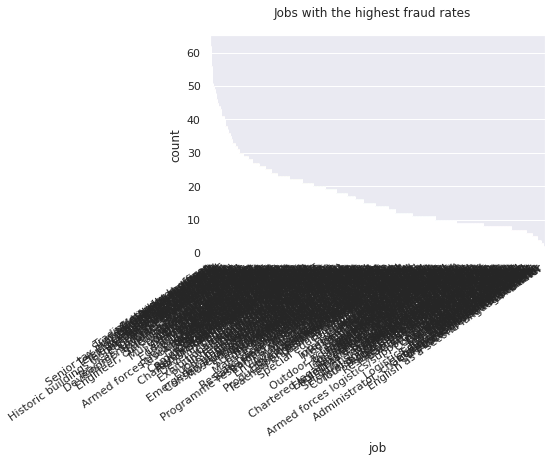

In [24]:
sns.countplot(
    data=df[df['is_fraud']==1], 
    x = "job", 
    order=df[df['is_fraud']==1]['job'].value_counts().index
    )
plt.xticks(rotation=35, ha='right')
plt.suptitle('Jobs with the highest fraud rates')

In [25]:
highest_fraud_job = df[df['is_fraud']==1]['job'].value_counts().index[0]
df[df['job']==highest_fraud_job][df['is_fraud']==1].shape[0]/df[df['is_fraud']==1].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.00826005861977085

Higest fraud job only holds 0.8% of the total frauds

In [26]:
len(df[df['is_fraud']==1]['job'].unique())/len(df['job'].unique())

0.8967611336032388

89% of the jobs have fraud events. Therefore, is not a feasible feature

In [27]:
df['cat_risk_score'] = df['category'].apply(lambda x: get_category_risk_score(x))
df.drop(columns=['merchant','category','job'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  200881 non-null  object 
 1   cc_num                 200881 non-null  int64  
 2   amt                    200881 non-null  float32
 3   gender                 200881 non-null  int64  
 4   lat                    200881 non-null  float32
 5   long                   200881 non-null  float32
 6   city_pop               200881 non-null  int64  
 7   dob                    200881 non-null  object 
 8   unix_time              200881 non-null  int64  
 9   merch_lat              200881 non-null  float32
 10  merch_long             200881 non-null  float32
 11  is_fraud               200881 non-null  int64  
 12  state_code             200881 non-null  int64  
 13  city_code              200881 non-null  int64  
 14  cat_risk_score         200881 non-n

In [28]:
#df.to_csv('/content/drive/MyDrive/PayU/df_advance')

## Date time parsing

Date and time of the transactions could relate fraud with seasonability. Then let's extract timestamp fields

In [29]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  200881 non-null  datetime64[ns]
 1   cc_num                 200881 non-null  int64         
 2   amt                    200881 non-null  float32       
 3   gender                 200881 non-null  int64         
 4   lat                    200881 non-null  float32       
 5   long                   200881 non-null  float32       
 6   city_pop               200881 non-null  int64         
 7   dob                    200881 non-null  datetime64[ns]
 8   unix_time              200881 non-null  int64         
 9   merch_lat              200881 non-null  float32       
 10  merch_long             200881 non-null  float32       
 11  is_fraud               200881 non-null  int64         
 12  state_code             200881 non-null  int

Extracting transactions' month, weekday, day and hour in case there is seasonability

In [ ]:
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_weekday'] = df['trans_date_trans_time'].dt.weekday
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['client_yob'] = df['dob'].dt.year
df.drop(columns=['trans_date_trans_time','dob'], inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200881 entries, 3 to 1296674
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cc_num          200881 non-null  int64  
 1   amt             200881 non-null  float32
 2   gender          200881 non-null  int64  
 3   lat             200881 non-null  float32
 4   long            200881 non-null  float32
 5   city_pop        200881 non-null  int64  
 6   unix_time       200881 non-null  int64  
 7   merch_lat       200881 non-null  float32
 8   merch_long      200881 non-null  float32
 9   is_fraud        200881 non-null  int64  
 10  state_code      200881 non-null  int64  
 11  city_code       200881 non-null  int64  
 12  cat_risk_score  200881 non-null  int64  
 13  trans_month     200881 non-null  int64  
 14  trans_day       200881 non-null  int64  
 15  trans_weekday   200881 non-null  int64  
 16  trans_hour      200881 non-null  int64  
 17  client_yo

#Final save checkpoint

In [33]:
df.to_csv('/content/drive/MyDrive/PayU/df_advance')

# Importance measurement

Now that we have only numerical values, statistical tests can be run to determine variable importance on predicting fraud.

Since we have numerical input and categorical output, ANOVA can be used for feature selection

In [42]:
x_colnames=df.columns[df.columns!="is_fraud"]
y_colnames="is_fraud"

X = df[x_colnames].to_numpy()
y = df[y_colnames].to_numpy().ravel()

In [50]:
len(x_colnames)

17

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Classification accuracy without selecting features: 0.970
Classification accuracy after univariate feature selection: 0.970


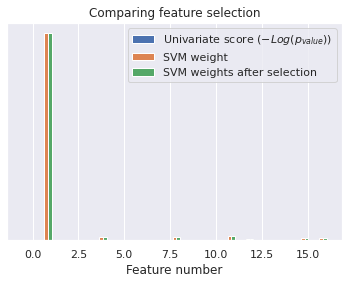

In [67]:
# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

selector = SelectKBest(f_classif, k=17)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=17), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')

plt.legend(loc='upper right')
plt.show()

In [68]:
df_score = pd.DataFrame()
df_score['f_name'] = x_colnames
df_score['f_index'] = X_indices
df_score['univariate_score']=scores
df_score['svm_weight'] = svm_weights
df_score['svm_weight_selected'] = svm_weights_selected
df_score

,f_name,f_index,univariate_score,svm_weight,svm_weight_selected
0,cc_num,0,0.0,0.000891,0.000891
1,amt,1,NaN,0.911100,0.911100
2,gender,2,0.0,0.001701,0.001701
3,lat,3,0.0,0.000764,0.000764
4,long,4,0.0,0.016651,0.016651
5,city_pop,5,0.0,0.001711,0.001711
6,unix_time,6,0.0,0.001561,0.001561
7,merch_lat,7,0.0,0.001902,0.001902
8,merch_long,8,0.0,0.015560,0.015560
9,state_code,9,0.0,0.000893,0.000892


In [78]:
df_score=df_score.sort_values(by="svm_weight_selected", ascending=False)
df_score

,f_name,f_index,univariate_score,svm_weight,svm_weight_selected
1,amt,1,NaN,0.911100,0.911100
11,cat_risk_score,11,NaN,0.019234,0.019234
4,long,4,0.0,0.016651,0.016651
8,merch_long,8,0.0,0.015560,0.015560
15,trans_hour,15,0.0,0.011553,0.011553
16,client_yob,16,0.0,0.009800,0.009800
12,trans_month,12,0.0,0.004175,0.004175
7,merch_lat,7,0.0,0.001902,0.001902
13,trans_day,13,0.0,0.001726,0.001726
5,city_pop,5,0.0,0.001711,0.001711


In [79]:
df_score['svm_weight_selected'][0:6].sum()

0.983897237422942

In [82]:
main_features = df_score['f_name'][0:6].values
main_features

array(['amt', 'cat_risk_score', 'long', 'merch_long', 'trans_hour',
       'client_yob'], dtype=object)

# Conclusion

 > **Features do not hold a linear relationship with fraud flag. However, using ML techniques it is possible to classify the transactions using DDBB features.**



> **The first 6 fatures from the ordered table hold 98.3% of the variance for a Support Vector Machine classification algorithm.**

#Validation

Let's validate the precision using different ML architechtures

In [5]:
df = pd.read_csv('df_advance.csv', index_col=0)
df.head()

,cc_num,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,state_code,city_code,cat_risk_score,trans_month,trans_day,trans_weekday,trans_hour,client_yob
3,3534093764340240,45.00,0,46.2306,-112.1138,1939,1325376076,47.034332,-112.561070,0,30,2978,5,1,1,1,0,1967
10,4642894980163,24.74,0,40.7491,-95.0380,7297,1325376383,40.275890,-96.011550,0,19,5105,1,1,1,1,0,1990
27,4334230547694630,6.85,0,43.0172,-111.0292,471,1325377292,43.753735,-111.454926,0,56,2088,6,1,1,1,0,1967
32,630412733309,66.21,1,46.3680,-87.9938,1038,1325377364,46.412037,-88.516660,0,26,8680,4,1,1,1,0,1964
34,374125201044065,9.03,0,38.9757,-77.0282,601723,1325377438,38.880898,-76.441120,0,11,1387,4,1,1,1,0,1970


Let's create a balanced training dataset

In [18]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)
    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs,ys

In [19]:
#x_colnames = main_features
x_colnames = ['amt', 'cat_risk_score', 'long', 'merch_long', 'trans_hour', 'client_yob']
y_colnames = "is_fraud"

In [25]:
X = df[x_colnames]
y = df[y_colnames]

X_train, y_train = balanced_subsample(X, y, subsample_size=0.7)

In [31]:
used_indexes = X_train.index.values
used_indexes

array([ 337475, 1237700,  449741, ...,  967090, 1097426,   81439])

In [24]:
def accuracy(confusion_matrix):
  diagonal_sum = confusion_matrix.trace()
  sum_of_all_elements = confusion_matrix.sum()
  return diagonal_sum / sum_of_all_elements 

In [38]:
X_test = X.drop(index=used_indexes)
y_test = df.loc[X_test.index.values][y_colnames].to_numpy().ravel()

### Support Vector Machine

0.9483225037163884


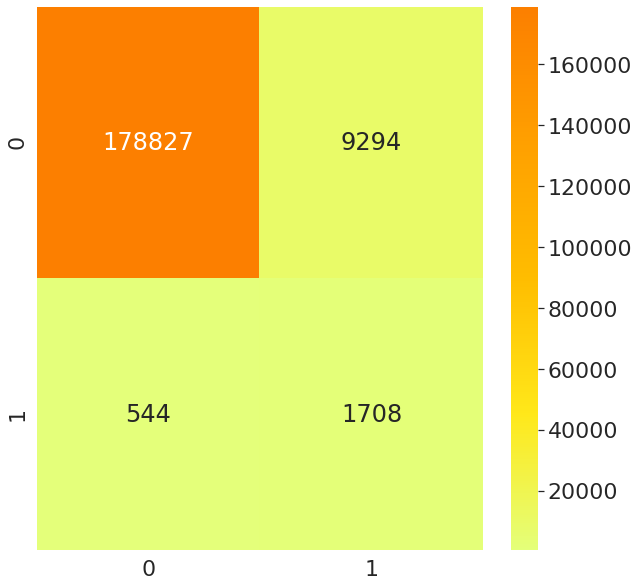

In [39]:
neigh = SVC()      
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

###CGBoost

0.9639969953722429


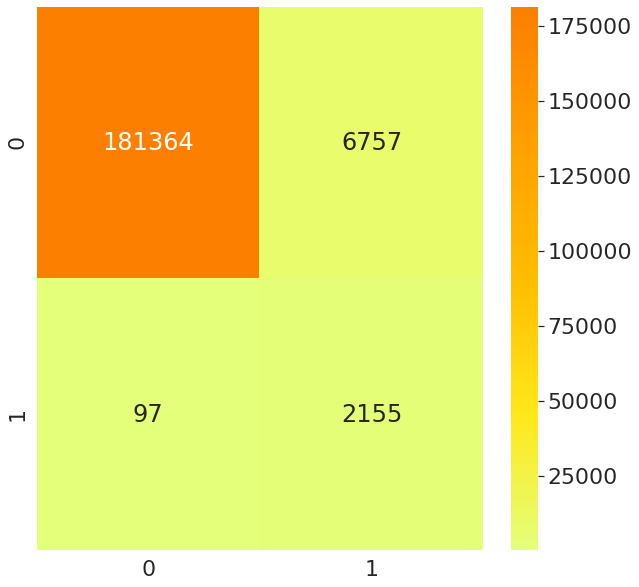

In [40]:
neigh = xgb.XGBClassifier()     
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

### AdaBoost

0.9522358737846228


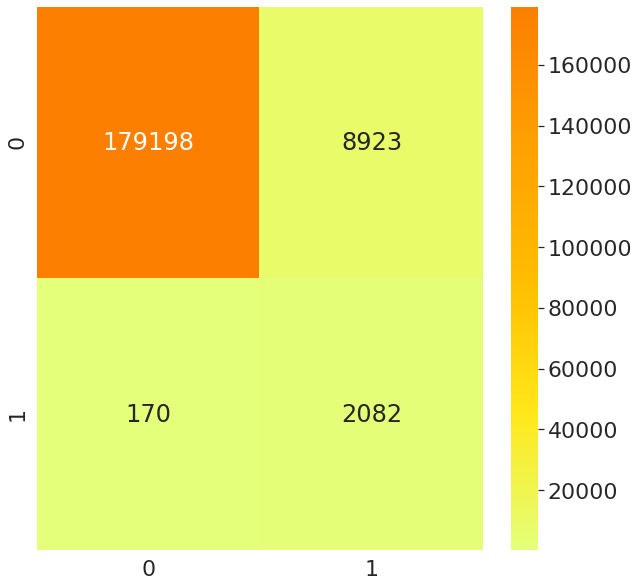

In [42]:
neigh = AdaBoostClassifier()    
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

### Decision Tree

0.9619378798464068


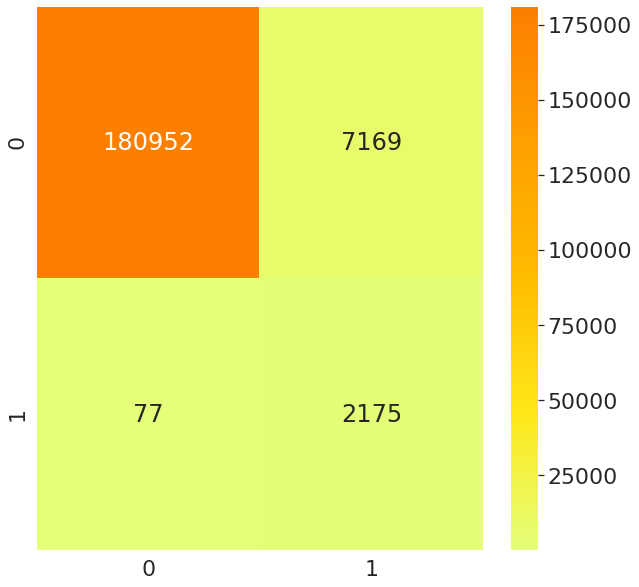

In [43]:
neigh = DecisionTreeClassifier()   
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

### Random Forest

0.972974108723401


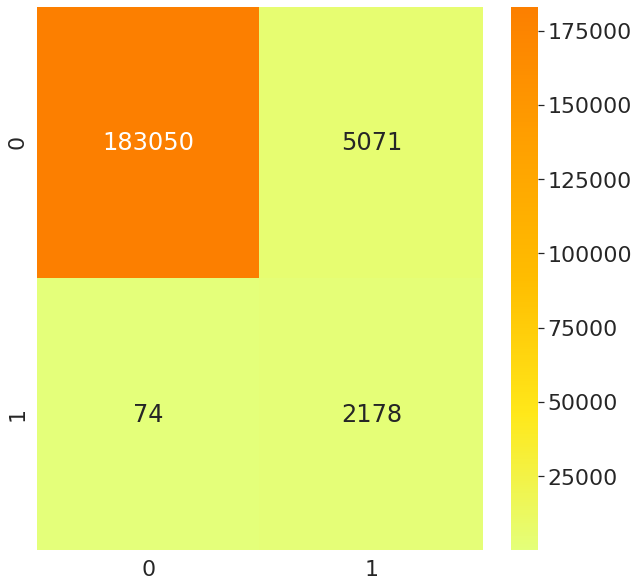

In [44]:
neigh = RandomForestClassifier()
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

### Gaussian NB

0.9691342784953749


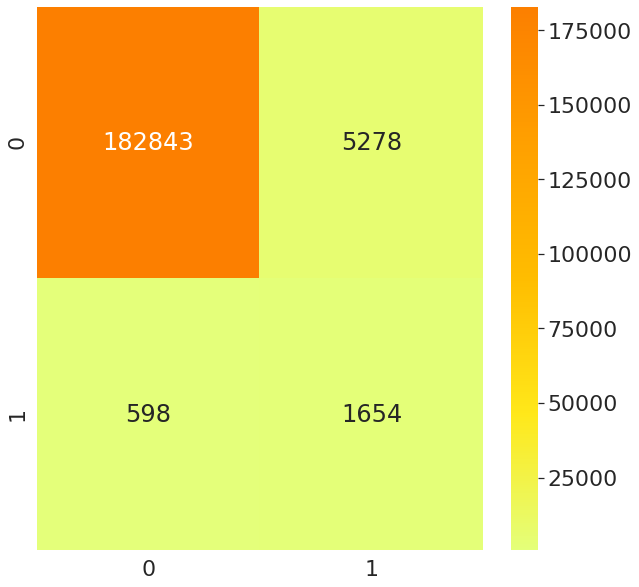

In [45]:
neigh = GaussianNB()
neigh_model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
actuals = y_test
conf = confusion_matrix(actuals, predictions)

sns. set(font_scale=2)
ax = sns.heatmap(conf,cmap="Wistia", annot=True, fmt='.0f')
ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

print(accuracy(conf))

##Conclusion

> **Standard ML models using main 6 parameters can predict fraud with over 95% accuracy**

> **Balancing the training dataset helped out making the training process shorter and improving overall accuracy**

> **Hyperparameter optimization techniques can improve the model's accuracy over the current results**